In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
import torch.optim as optim
from cebra_utils import *

In [17]:
cebra_model_path = 'models/cebra_model_complete.pt'

data_directory = '/mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

label_paths = list(filter(lambda x : x.endswith('.pickle') , iter(os.listdir('.'))))

In [3]:
num_classes = 4
solver = torch.load('models/cebra_model_complete.pt')
model_group = solver.model.eval()
prototype = nn.Sequential(nn.Linear(8, 4))
classifiers = nn.ModuleList([prototype for i in range(len(model_group))])
for param in model_group.parameters():
    param.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifiers.parameters(), lr=0.001)

In [6]:
def single_epoch(data, names, labels, model_group, criterion, optimizer, session):
    # train the linear classifier on the labelled data
    running_loss = 0.0
    num_iter= 0
    for data, names in zip(data, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = model_group[session](torch.from_numpy(data).float())
            tiled_label = np.tile(labels[names], data.shape[0]).reshape(data.shape[0], 4)
            vid_label = torch.from_numpy(tiled_label).float()

            loss = criterion(output, vid_label)

            # do a backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_iter += 1
            
    return (running_loss / num_iter)
            

def validation_run(data, names, labels, model_group, criterion, session):
    # train the linear classifier on the labelled data
    running_loss = 0.0
    num_iter= 0
    for data, names in zip(data, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = model_group[session](torch.from_numpy(data).float())
            tiled_label = np.tile(labels[names], data.shape[0]).reshape(data.shape[0], 4)
            vid_label = torch.from_numpy(tiled_label).float()

            loss = criterion(output, vid_label)

            running_loss += loss.item()
            num_iter += 1
            
    return (running_loss / num_iter)

In [ ]:
for i in range(len(label_paths)):
    with open(label_paths[i], 'rb') as f:
        labels = pickle.load(f)

    # load the data
    data, names = import_data(neural_data_paths[i], lambda x: x, min = 0, max = 0.15)
    validation_data, validation_names  = import_data(neural_data_paths[i], lambda x: x, min = 0.15, max = 0.2)

    # generate embeddings
    embeddings = []
    for vid in data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        embeddings.append(single_embeddings)

    validation_embeddings = []
    for vid in validation_data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        validation_embeddings.append(single_embeddings)

    loss = []
    valid_loss = []
    for epoch in range(10000): 
        loss.append(single_epoch(embeddings, names, labels, classifiers, criterion, optimizer, i))
        valid_loss.append(validation_run(validation_embeddings, validation_names, labels, classifiers, criterion, i))

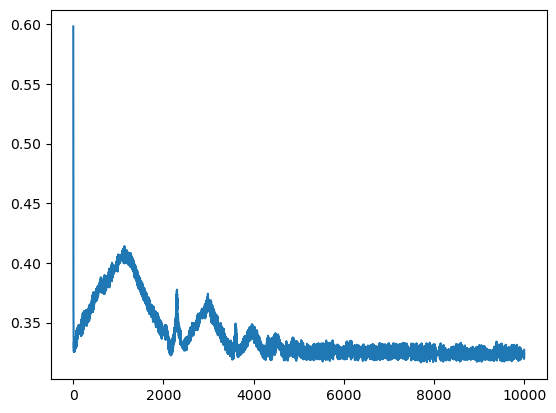

In [7]:
torch.save(classifiers, 'models/cebra_classifier_complete.pt')